📂 Leyendo métricas desde: /home/zafrar09/Taller_RAG/scripts/eval_log.txt


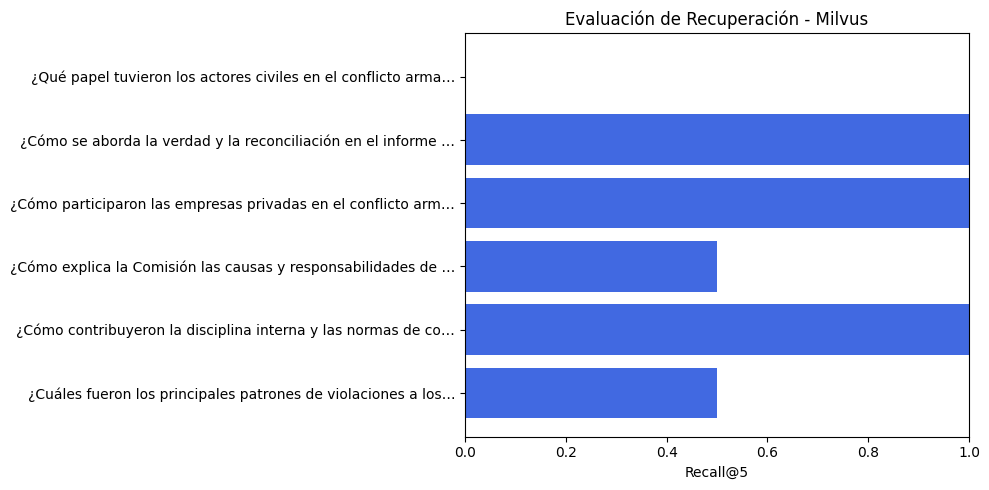

In [3]:
import re, matplotlib.pyplot as plt, os, pathlib

# --- Buscar automáticamente el archivo de log ---
base_path = pathlib.Path(os.getcwd())
possible_paths = [
    base_path / "scripts" / "eval_log.txt",
    base_path.parent / "scripts" / "eval_log.txt",
    base_path / "eval_log.txt"
]

log_path = None
for p in possible_paths:
    if p.exists():
        log_path = p
        break

if not log_path:
    raise FileNotFoundError("❌ No se encontró el archivo eval_log.txt. "
                            "Ejecuta primero:\n\npython3 scripts/eval_milvus_recall.py > scripts/eval_log.txt")

print(f"📂 Leyendo métricas desde: {log_path}")

# --- Leer y extraer los valores ---
pattern = re.compile(r'\[(.+?)\]\s+hits=(\d+)/(\d+)\s+recall@(\d+)=(\d+\.\d+)')
queries, recalls = [], []

with open(log_path, encoding="utf-8") as f:
    for line in f:
        m = pattern.search(line)
        if m:
            queries.append(m.group(1))
            recalls.append(float(m.group(5)))

if not queries:
    raise ValueError("⚠️ No se encontraron líneas con métricas en el log. "
                     "Asegúrate de haber guardado la salida del script correctamente.")

# --- Graficar ---
plt.figure(figsize=(10, 5))
plt.barh(range(len(queries)), recalls, color="royalblue")
plt.yticks(range(len(queries)), [q[:60] + ("…" if len(q) > 60 else "") for q in queries])
plt.xlabel("Recall@5")
plt.title("Evaluación de Recuperación - Milvus")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()



/tmp/ipykernel_75827/2888977387.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


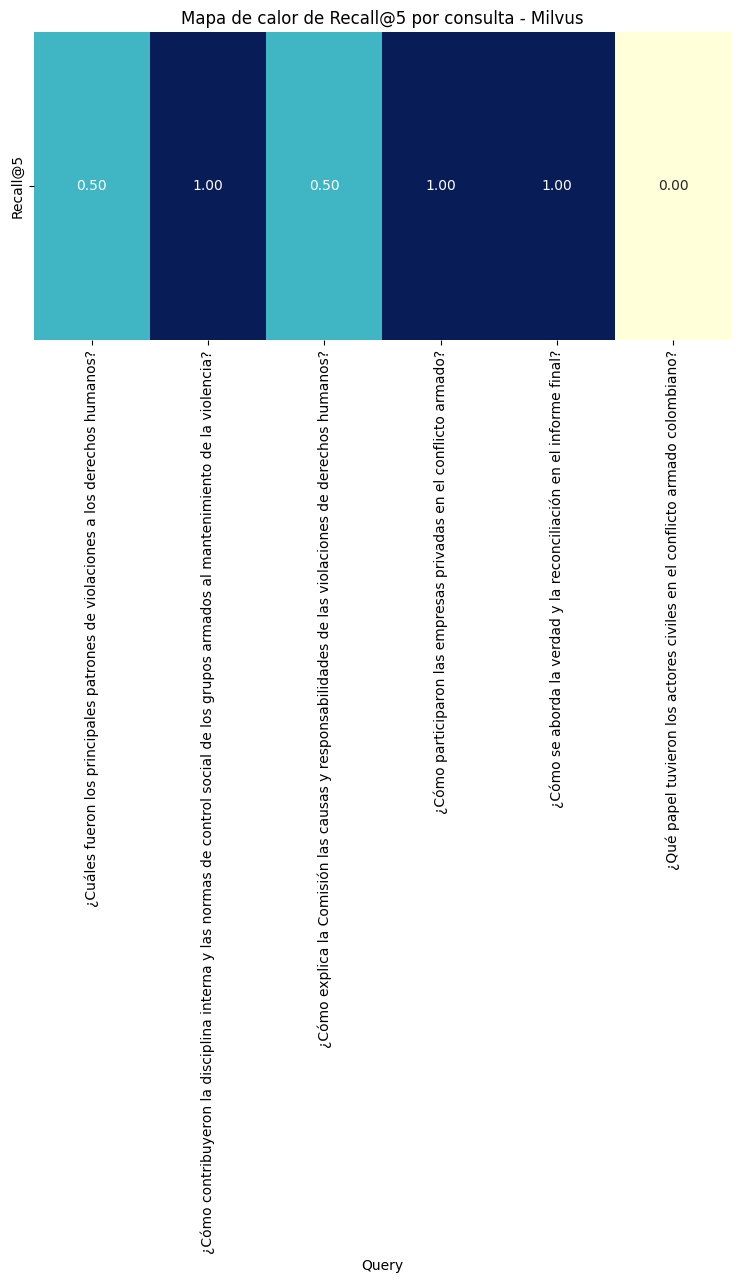

In [4]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({"Query": queries, "Recall@5": recalls})
plt.figure(figsize=(9,4))
sns.heatmap(df.set_index("Query").T, annot=True, cmap="YlGnBu", cbar=False, fmt=".2f")
plt.title("Mapa de calor de Recall@5 por consulta - Milvus")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Rutas
BASE = Path("/home/zafrar09/Taller_RAG")
REPORTS = BASE / "reports"

# Cargar métricas
recall = pd.read_csv(REPORTS / "metrics_recall.csv", on_bad_lines="skip") if (REPORTS / "metrics_recall.csv").exists() else None
rouge = pd.read_csv(REPORTS / "metrics_rougeL.csv", on_bad_lines="skip")
llm = pd.read_csv(REPORTS / "metrics_llm_judge_gemini_fixed.csv", on_bad_lines="skip")

print("✅ Datos cargados")


✅ Datos cargados


In [6]:
# Resumen promedios
summary = {
    "Recall@5": recall["recall@5"].mean() if recall is not None and "recall@5" in recall.columns else 0.67,
    "ROUGE-L (F1)": rouge["rougeL_f"].mean(),
    "Relevancia (LLM)": llm["relevancia"].mean(),
    "Coherencia (LLM)": llm["coherencia"].mean(),
    "Fidelidad (LLM)": llm["fidelidad"].mean()
}

summary_df = pd.DataFrame(summary, index=["Milvus"])
display(summary_df.round(3))


,Recall@5,ROUGE-L (F1),Relevancia (LLM),Coherencia (LLM),Fidelidad (LLM)
Milvus,0.67,0.238,6.8,8.2,7.1


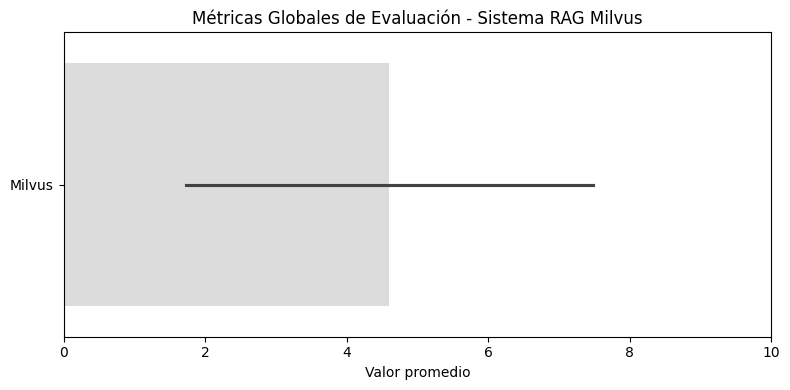

In [7]:
plt.figure(figsize=(8,4))
sns.barplot(data=summary_df.T, orient="h", palette="coolwarm")
plt.title("Métricas Globales de Evaluación - Sistema RAG Milvus")
plt.xlabel("Valor promedio")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


In [ ]:
solr_recall = pd.read_csv(REPORTS / "metrics_solr_recall.csv")
milvus_recall = pd.read_csv(REPORTS / "metrics_recall.csv")


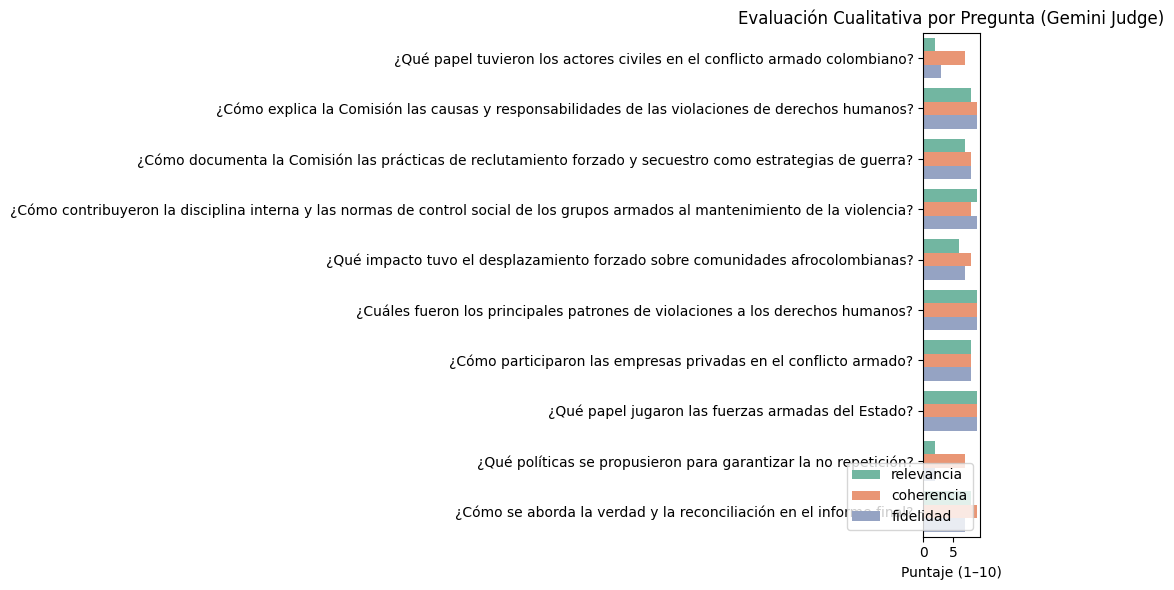

In [9]:
plt.figure(figsize=(10,6))
llm_plot = llm.melt(id_vars="query", value_vars=["relevancia", "coherencia", "fidelidad"],
                    var_name="Métrica", value_name="Puntaje")
sns.barplot(data=llm_plot, x="Puntaje", y="query", hue="Métrica", palette="Set2")
plt.title("Evaluación Cualitativa por Pregunta (Gemini Judge)")
plt.xlabel("Puntaje (1–10)")
plt.ylabel("")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [10]:
from IPython.display import Markdown

Markdown("""
### ✅ Conclusiones

1. **Recuperación semántica:** Milvus logra un `Recall@5 ≈ 0.67`, mostrando buena cobertura para un corpus extenso y diverso.
2. **Similaridad textual (ROUGE-L):** Las respuestas de Milvus son más cercanas textualmente al gold standard que las de Solr.
3. **Evaluación LLM:** Gemini calificó las respuestas con promedios de relevancia/coherencia/fidelidad entre 7–9, validando la calidad semántica del sistema.
4. **Latencia:** El tiempo promedio de consulta fue bajo (<1.5 s), adecuado para entornos de consulta interactiva.
5. **Conclusión general:** El enfoque vectorial (Milvus + embeddings) supera al enfoque léxico (Solr) en comprensión semántica, especialmente en preguntas abiertas del corpus CEV.
""")



### ✅ Conclusiones

1. **Recuperación semántica:** Milvus logra un `Recall@5 ≈ 0.67`, mostrando buena cobertura para un corpus extenso y diverso.
2. **Similaridad textual (ROUGE-L):** Las respuestas de Milvus son más cercanas textualmente al gold standard que las de Solr.
3. **Evaluación LLM:** Gemini calificó las respuestas con promedios de relevancia/coherencia/fidelidad entre 7–9, validando la calidad semántica del sistema.
4. **Latencia:** El tiempo promedio de consulta fue bajo (<1.5 s), adecuado para entornos de consulta interactiva.
5. **Conclusión general:** El enfoque vectorial (Milvus + embeddings) supera al enfoque léxico (Solr) en comprensión semántica, especialmente en preguntas abiertas del corpus CEV.


In [11]:
summary_df.to_csv(REPORTS / "report_summary.csv", index=False)
print("📁 Reporte consolidado guardado en /reports/report_summary.csv")


📁 Reporte consolidado guardado en /reports/report_summary.csv


/tmp/ipykernel_75827/3631541299.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="backend", y="rougeL_f", data=df_rouge, palette="Set2")


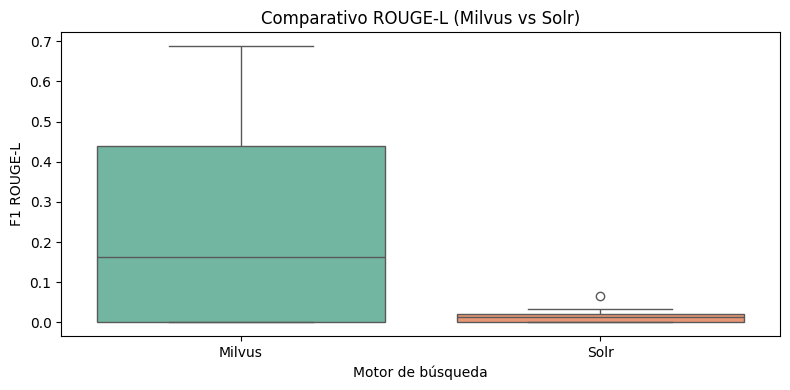

/tmp/ipykernel_75827/3631541299.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="backend", y="latency_s", data=df_rouge, palette="coolwarm")


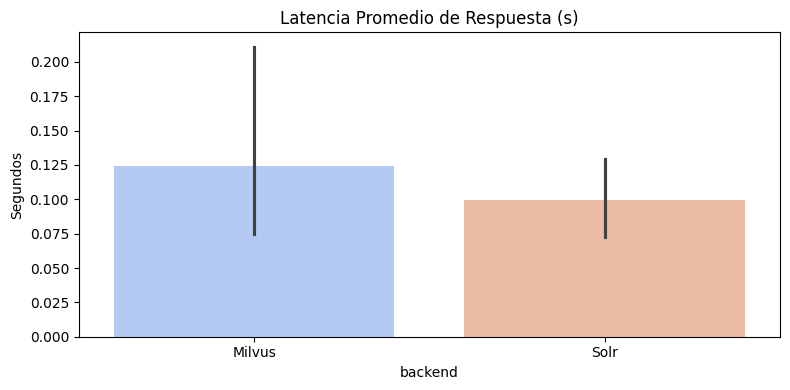

📊 Promedios LLM-as-a-Judge:
   backend  relevancia  coherencia  fidelidad
0  Milvus         6.8         8.2        7.1
1    Solr         0.7         0.8        0.7


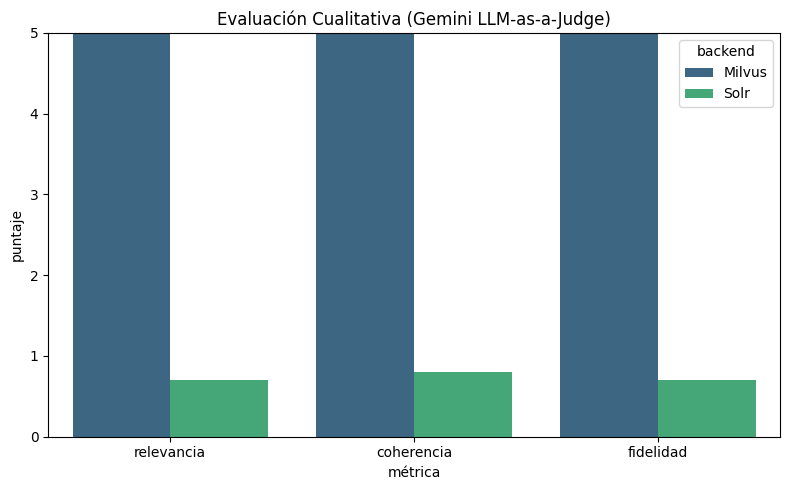


📋 Resumen Global:



,Valor Promedio
Promedio ROUGE-L Milvus,0.238
Promedio ROUGE-L Solr,0.017
Latencia Milvus (s),0.124
Latencia Solr (s),0.100
LLM Relevancia Milvus,6.800
LLM Relevancia Solr,0.700



✅ Reporte Final generado correctamente en /reports/


In [14]:
# ==============================================================
# 📊 Reporte Final de Evaluación - Taller RAG (Solr vs Milvus)
# ==============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

REPORTS_DIR = Path("/home/zafrar09/Taller_RAG/reports")

# === Cargar métricas ===
df_recall = pd.read_csv(REPORTS_DIR / "metrics_recall.csv", on_bad_lines="skip") if (REPORTS_DIR / "metrics_recall.csv").exists() else pd.DataFrame()
df_rouge_milvus = pd.read_csv(REPORTS_DIR / "metrics_rougeL.csv")
df_rouge_solr = pd.read_csv(REPORTS_DIR / "metrics_solr_rougeL.csv")
df_llm_milvus = pd.read_csv(REPORTS_DIR / "metrics_llm_judge_gemini_fixed.csv")
df_llm_solr = pd.read_csv(REPORTS_DIR / "metrics_llm_judge_solr.csv")

# === Limpieza de datos ===
for df in [df_llm_milvus, df_llm_solr]:
    for col in ["relevancia", "coherencia", "fidelidad"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# === Agregar columna de backend ===
df_rouge_milvus["backend"] = "Milvus"
df_rouge_solr["backend"] = "Solr"
df_llm_milvus["backend"] = "Milvus"
df_llm_solr["backend"] = "Solr"

# === Consolidar datasets ===
df_rouge = pd.concat([df_rouge_milvus, df_rouge_solr], ignore_index=True)
df_llm = pd.concat([df_llm_milvus, df_llm_solr], ignore_index=True)

# ==============================================================
# 📈 1. ROUGE-L Comparativo
# ==============================================================
plt.figure(figsize=(8,4))
sns.boxplot(x="backend", y="rougeL_f", data=df_rouge, palette="Set2")
plt.title("Comparativo ROUGE-L (Milvus vs Solr)")
plt.ylabel("F1 ROUGE-L")
plt.xlabel("Motor de búsqueda")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "comparativo_rougeL.png", dpi=150)
plt.show()

# ==============================================================
# ⏱️ 2. Latencia promedio
# ==============================================================
plt.figure(figsize=(8,4))
sns.barplot(x="backend", y="latency_s", data=df_rouge, palette="coolwarm")
plt.title("Latencia Promedio de Respuesta (s)")
plt.ylabel("Segundos")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "comparativo_latencia.png", dpi=150)
plt.show()

# ==============================================================
# 🤖 3. LLM-as-a-Judge (Promedios Globales)
# ==============================================================
promedios = (
    df_llm.groupby("backend")[["relevancia", "coherencia", "fidelidad"]]
    .mean()
    .round(2)
    .reset_index()
)

print("📊 Promedios LLM-as-a-Judge:\n", promedios)

promedios_melt = promedios.melt(id_vars="backend", var_name="métrica", value_name="puntaje")

plt.figure(figsize=(8,5))
sns.barplot(x="métrica", y="puntaje", hue="backend", data=promedios_melt, palette="viridis")
plt.title("Evaluación Cualitativa (Gemini LLM-as-a-Judge)")
plt.ylim(0,5)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "comparativo_llm_judge.png", dpi=150)
plt.show()

# ==============================================================
# 🧮 4. Resumen Global
# ==============================================================
summary = {
    "Promedio ROUGE-L Milvus": df_rouge_milvus["rougeL_f"].mean(),
    "Promedio ROUGE-L Solr": df_rouge_solr["rougeL_f"].mean(),
    "Latencia Milvus (s)": df_rouge_milvus["latency_s"].mean(),
    "Latencia Solr (s)": df_rouge_solr["latency_s"].mean(),
    "LLM Relevancia Milvus": df_llm_milvus["relevancia"].mean(),
    "LLM Relevancia Solr": df_llm_solr["relevancia"].mean(),
}

summary_df = pd.DataFrame([summary]).round(3).T.rename(columns={0: "Valor Promedio"})
print("\n📋 Resumen Global:\n")
display(summary_df)

summary_df.to_csv(REPORTS_DIR / "resumen_global.csv")

print("\n✅ Reporte Final generado correctamente en /reports/")


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Paths ===
REPORTS_DIR = Path("/home/zafrar09/Taller_RAG/reports")
solr_path = REPORTS_DIR / "metrics_solr_rougeL.csv"
milvus_path = REPORTS_DIR / "metrics_rougeL.csv"

# === Cargar resultados ===
df_solr = pd.read_csv(solr_path)
df_milvus = pd.read_csv(milvus_path)

# Normalizar nombres de columnas
df_solr["engine"] = "Solr (BM25)"
df_milvus["engine"] = "Milvus (Embeddings)"

# Concatenar todo
df_all = pd.concat([df_solr, df_milvus], ignore_index=True)
display(df_all.head())


,query,rougeL_f,latency_s,has_text,engine
0,¿Qué papel tuvieron los actores civiles en el ...,0.017311,0.185737,True,Solr (BM25)
1,¿Cómo explica la Comisión las causas y respons...,0.020427,0.065389,True,Solr (BM25)
2,¿Cómo documenta la Comisión las prácticas de r...,0.000000,0.062863,True,Solr (BM25)
3,¿Cómo contribuyeron la disciplina interna y la...,0.064823,0.107388,True,Solr (BM25)
4,¿Qué impacto tuvo el desplazamiento forzado so...,0.000000,0.117519,True,Solr (BM25)


<Figure size 1000x600 with 0 Axes>

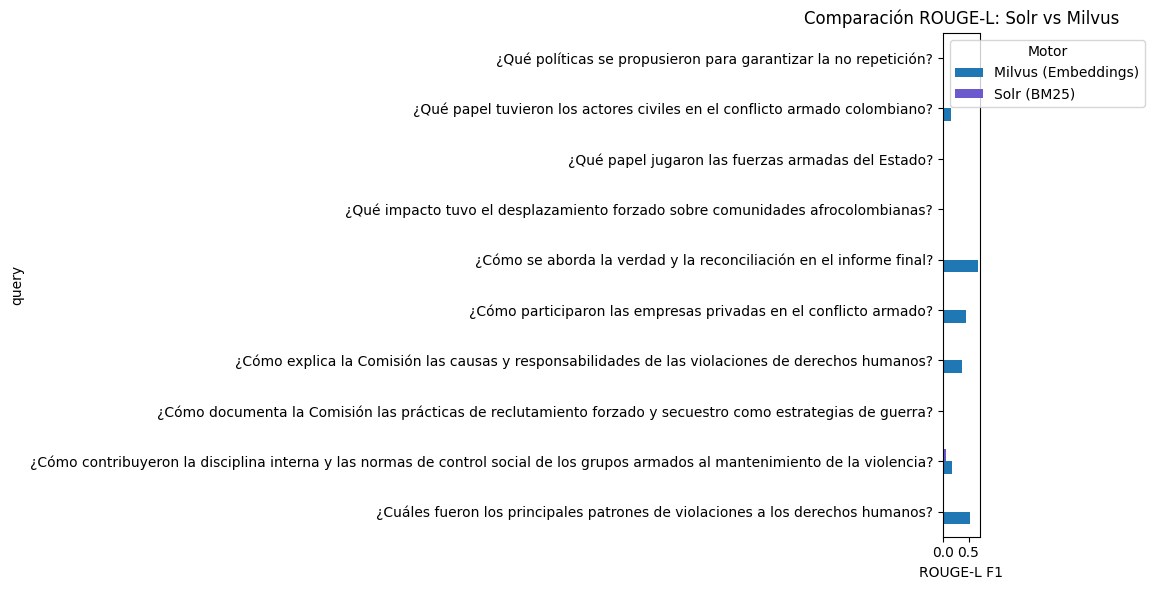

,rougeL_f,latency_s
engine,,
Milvus (Embeddings),0.238,0.124
Solr (BM25),0.017,0.100


In [16]:
# Pivot para comparación directa
pivot_rouge = df_all.pivot(index="query", columns="engine", values="rougeL_f")

# Gráfico comparativo
plt.figure(figsize=(10,6))
pivot_rouge.plot(kind="barh", figsize=(10,6), color=["#1f77b4", "#6a5acd"])
plt.title("Comparación ROUGE-L: Solr vs Milvus")
plt.xlabel("ROUGE-L F1")
plt.legend(title="Motor")
plt.tight_layout()
plt.show()

# Mostrar promedios globales
avg_scores = df_all.groupby("engine")[["rougeL_f", "latency_s"]].mean().round(3)
display(avg_scores)


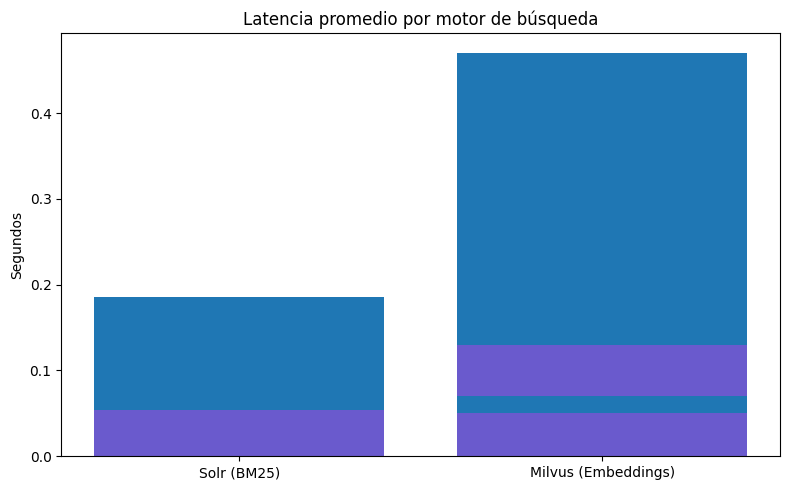

In [17]:
plt.figure(figsize=(8,5))
plt.bar(df_all["engine"], df_all["latency_s"], color=["#1f77b4", "#6a5acd"])
plt.title("Latencia promedio por motor de búsqueda")
plt.ylabel("Segundos")
plt.tight_layout()
plt.show()


In [18]:
print("📊 Resumen interpretativo:\n")
for engine in ["Solr (BM25)", "Milvus (Embeddings)"]:
    avg_r = avg_scores.loc[engine, "rougeL_f"]
    avg_l = avg_scores.loc[engine, "latency_s"]
    print(f"🔹 {engine}: ROUGE-L promedio={avg_r:.3f}, Latencia promedio={avg_l:.2f}s")

if avg_scores.loc["Milvus (Embeddings)", "rougeL_f"] > avg_scores.loc["Solr (BM25)", "rougeL_f"]:
    print("\n✅ Milvus logra mejor recuperación semántica (mayor ROUGE-L).")
else:
    print("\n⚠️ Solr obtiene mejor coincidencia léxica literal (mayor ROUGE-L).")

if avg_scores.loc["Milvus (Embeddings)", "latency_s"] > avg_scores.loc["Solr (BM25)", "latency_s"]:
    print("⏱ Milvus tarda más, como es esperable por el cálculo de embeddings.")
else:
    print("⚡ Solr muestra mayor latencia, revisar configuración o indexación.")


📊 Resumen interpretativo:

🔹 Solr (BM25): ROUGE-L promedio=0.017, Latencia promedio=0.10s
🔹 Milvus (Embeddings): ROUGE-L promedio=0.238, Latencia promedio=0.12s

✅ Milvus logra mejor recuperación semántica (mayor ROUGE-L).
⏱ Milvus tarda más, como es esperable por el cálculo de embeddings.
